## Условие 

In [ ]:
Проект: вариант 3
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. 
Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* 
при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

1. Был ли эксперимент успешен в целом.
2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

In [ ]:
Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:
transactions_*.csv – информация о платежах пользователей:

### Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statistics
import datetime
from operator import attrgetter
import matplotlib.colors as mcolors
import matplotlib as mpl
import scipy.stats as statss
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

### ФУНКЦИИ ИСПОЛЬЗУЕМЫЕ В РАБОТЕ

#### Функция, реализующая бутстрап с выводом среднего в контрольной группе и среднего разницы 2х сравниваемых групп, а так же построение графика разниц 2х групп с границами 95-ти% доверительного интервала

In [3]:
def bootstrap(control,test):
    control_arr  = control.revenue.values
    test_arr     = test.revenue.values
    bank_control = []
    bank_test    = []
    bank         = []
    
    n = 10000
    m = 10000
    for i in tqdm(range(n)):
        samp_control     = np.random.choice(control_arr, size = m, replace = True)
        samp_test = np.random.choice(test_arr, size = m, replace = True)
        bank_control.append(np.mean(samp_control))
        bank_test.append(np.mean(samp_test))
        bank.append(np.mean(samp_test) - np.mean(samp_control))
    sns.histplot(pd.Series(bank), bins=50)
    print(np.mean(bank_control))
    print(np.mean(bank))
    print([np.quantile(bank, q=0.025), np.quantile(bank, q=0.975)])

#### Функция реализации таблицы с когортами Retention'а для транзакций пользователя

In [4]:
def table_cog(df_cog):
    '''Построение таблицы с когортами Retentiona'''
    df_cog['month_pay'] = df_cog["paid_at"].dropna().dt.to_period("M")
    df_cog['cohort'] = df_cog.groupby('uid')['paid_at'] \
                                 .transform('min').dt.to_period('M') #дата первой транзы челов
    df_cohort = df_cog.groupby(['cohort', 'month_pay']) \
                     .agg(n_customers=('uid', 'nunique')).reset_index(drop=False)
    df_cohort['period_number'] = (df_cohort.month_pay - df_cohort.cohort).apply(attrgetter('n'))
    cohort_pivot = df_cohort.pivot_table(index='cohort', 
                                         columns='period_number', 
                                         values='n_customers')
    return cohort_pivot

#### Функция построения наглядной визуализации когорт Retention'а

In [5]:
def cog_matrix(cohort_pivot):
    ''' Построение визуализации когорт удержания пользователей'''
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, 
                               gridspec_kw={'width_ratios': [1, 11]})

        sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, 
                    fmt='.0%', cmap='RdYlGn', ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='# of periods', ylabel='')

        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, annot=True, cbar=False, 
                    fmt='g', cmap=white_cmap, ax=ax[0])
        fig.tight_layout()

#### Функция создания датафрейма с датами посещения юзера, где дата посещения юзера представлена в формате ДД-ММ-ГГГГ, где каждый день посещения представлен отдельной строкой в ДФ

In [6]:
def convert_visits(df1):
    df = pd.DataFrame(df1[['uid','paid_at', 'visit_days']])

    # # Разделяем строку с днями на списки
    df = df.drop_duplicates()
    df['days'] = df['visit_days'].str.split(',')
    df['first_pay'] = df.groupby('uid')['paid_at'].transform('min').dt.to_period('D')
    df = df.drop_duplicates('visit_days')
    df
    # # "Взрываем" список в новые строки
    exploded_df = df.explode('days')
    exploded_df['days'] = exploded_df['first_pay'] + exploded_df.days.apply(lambda x: int(x)) - 1
    return exploded_df

#### Функция реализации когорты Retention'а для дней посещения пользователя

In [7]:
def table_cog_visits(df_cog):
    '''Построение таблицы с когортами Retentiona'''
    df_cog['month_vis'] = df_cog['days'].dropna().dt.to_timestamp().dt.to_period('M')
    df_cog['cohort'] = df_cog['first_pay'].dropna().dt.to_timestamp().dt.to_period('M') #дата первой транзы челов
    df_cohort = df_cog.groupby(['cohort', 'month_vis']) \
                     .agg(n_customers=('uid', 'nunique')).reset_index(drop=False)
    df_cohort['period_number'] = (df_cohort.month_vis - df_cohort.cohort).apply(attrgetter('n'))
    cohort_pivot = df_cohort.pivot_table(index='cohort', 
                                         columns='period_number', 
                                         values='n_customers')
    return cohort_pivot

#### Считывание данных нам таблиц и первоначальная предобработка

In [8]:
users_control_1        = pd.read_csv('users_control_1.csv', sep = ';')
users_control_2        = pd.read_csv('users_control_2.csv', sep = ';')
users_test             = pd.read_csv('users_test.csv', sep = ';')
transactions_control_1 = pd.read_csv('transactions_control_1.csv', sep = ';')
transactions_control_2 = pd.read_csv('transactions_control_2.csv', sep = ';')
transactions_test      = pd.read_csv('transactions_test.csv', sep = ';')

In [9]:
users_control_1 = users_control_1.dropna(how = 'all')
users_control_2 = users_control_2.dropna(how = 'all') 
users_test = users_test.dropna(how = 'all')
transactions_control_1 = transactions_control_1.dropna()
transactions_control_2 = transactions_control_2.dropna()
transactions_test = transactions_test.dropna()

In [10]:
control_1 = users_control_1.merge(transactions_control_1, how = 'inner', on = ['uid', 'country'])
control_2 = users_control_2.merge(transactions_control_2, how = 'inner', on = ['uid', 'country'])
test = users_test.merge(transactions_test, how = 'inner', on = ['uid', 'country'])

#### Добавление колонки с месяцем регистрации и перевод нужных колонок в нужный нам формат времени

In [11]:
test['joined_at'] = pd.to_datetime(test['joined_at'])
control_1['joined_at'] = pd.to_datetime(control_1['joined_at'])
control_2['joined_at'] = pd.to_datetime(control_2['joined_at'])
test['paid_at'] = pd.to_datetime(test['paid_at'])
control_1['paid_at'] = pd.to_datetime(control_1['paid_at'])
control_2['paid_at'] = pd.to_datetime(control_2['paid_at'])

In [12]:
transactions_control_1["joined_at"] = pd.to_datetime(control_1['joined_at'])
transactions_control_2["joined_at"] = pd.to_datetime(control_2['joined_at'])
transactions_test["joined_at"] = pd.to_datetime(test['joined_at'])

transactions_control_1["paid_at"] = pd.to_datetime(control_1['paid_at'])
transactions_control_2["paid_at"] = pd.to_datetime(control_2['paid_at'])
transactions_test["paid_at"] = pd.to_datetime(test['paid_at'])

In [13]:
transactions_control_1['month_reg'] = transactions_control_1["joined_at"].dropna().dt.to_period("M").apply(lambda x: str(x))
transactions_control_2['month_reg'] = transactions_control_2["joined_at"].dropna().dt.to_period("M").apply(lambda x: str(x))
transactions_test['month_reg'] = transactions_test["joined_at"].dropna().dt.to_period("M").apply(lambda x: str(x))

In [27]:
control_1['visit_days'] = control_1['visit_days'].apply(lambda x: '0' if x is np.NaN else x)
control_2['visit_days'] = control_2['visit_days'].apply(lambda x: '0' if x is np.NaN else x)
test['visit_days'] = test['visit_days'].apply(lambda x: '0' if x is np.NaN else x)

#### Первый взгляд на содержимое таблиц

In [17]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [18]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,month_reg
0,891319275.0,France,2017-02-11 15:07:00,2017-02-11 17:16:00,12727.0,147.0,trial_vip_popup,trial_premium,2017-02
1,892421826.0,Israel,2017-02-11 15:07:00,2017-04-11 02:25:00,14586.0,147.0,trial_vip_popup,trial_premium,2017-02
2,891822480.0,Italy,2017-10-15 09:11:00,2017-10-15 09:23:00,1911.0,19.0,none,coins,2017-10
3,891367521.0,Italy,2017-06-11 03:51:00,2017-06-11 03:59:00,1456.0,127.0,sympathy,other_type,2017-06
4,892207959.0,France,2017-10-16 00:21:00,2017-10-16 00:51:00,1261.0,19.0,empty_likes,coins,2017-10


#### Размеры датафреймов юзеров и транзакций

In [19]:
users_control_1.shape

(4340, 13)

In [20]:
users_control_2.shape

(4264, 13)

In [21]:
users_test.shape

(4308, 13)

In [22]:
transactions_control_1.shape

(377, 9)

In [23]:
transactions_control_2.shape

(328, 9)

In [24]:
transactions_test.shape

(273, 9)

### Даты первых и последних транзакций по группам

In [28]:
control_1.paid_at.min()

'2016-12-14 16:16:00'

In [24]:
control_1.paid_at.sort_values().head()

33    2016-12-14 16:16:00
31    2016-12-14 17:30:00
32    2016-12-14 17:35:00
374   2017-01-11 02:56:00
296   2017-01-11 04:10:00
Name: paid_at, dtype: datetime64[ns]

In [28]:
control_1.paid_at.max()

Timestamp('2017-12-11 21:57:00')

In [30]:
control_2.paid_at.min()

'2017-01-11 05:34:00'

In [31]:
control_2.paid_at.max()

'2017-12-11 23:28:00'

In [32]:
test.paid_at.min()

'2017-01-11 04:37:00'

In [33]:
test.paid_at.max()

'2017-12-11 22:06:00'

#### Есть 3 транзакции в 1 контрольной группе, которые происходят до основного промежутка 2017-01-11 -- 2017-12-11 (обращаем внимание)

### Рассмотрение вопроса, успешен ли в целом эксперимент

### ARPU для любых покупок пользователей

In [22]:
prod = transactions_control_1.revenue.sum() / transactions_control_1.uid.count()
prod

6929.206896551724

In [21]:
prod = transactions_control_2.revenue.sum() / transactions_control_2.uid.count()
prod

5854.993902439024

In [20]:
prod = transactions_test.revenue.sum() / transactions_test.uid.count()
prod

8589.380952380952

In [23]:
money_per_user = transactions_control_1.groupby('uid', as_index=False).agg({'revenue': 'sum'})
money_per_user.head()

,uid,revenue
0,891092322.0,9945.0
1,891120969.0,6292.0
2,891130164.0,11869.0
3,891131061.0,10075.0
4,891135642.0,962.0


#### Для первой контрольной группы посмотрим на распределение ARPU и проверим его на нормальность

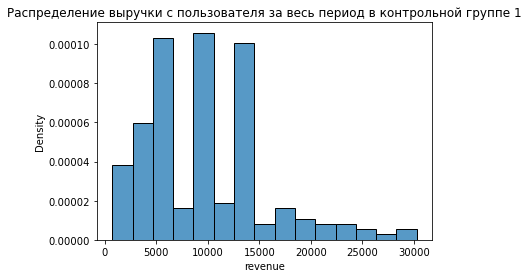

In [25]:
sns.histplot(data=money_per_user.query('revenue < 50000'), x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Распределение выручки с пользователя за весь период в контрольной группе 1");

##### берем выручку с человека меньшую 50.000, так как следует убрать выбросы

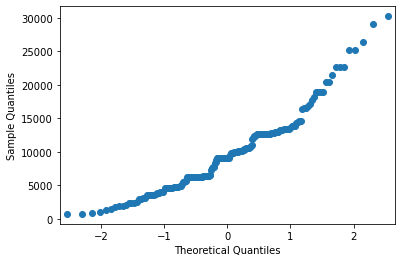

In [27]:
# проверка на нормальность распределения
sm.qqplot(money_per_user.query('revenue < 50000').revenue)
plt.show()

In [38]:
stats.normaltest(money_per_user.query('revenue < 50000').revenue)

NormaltestResult(statistic=30.402196573501534, pvalue=2.5017672051421046e-07)

### Распределение не является нормальным, так как pvalue << 0.05

#### Аналогично рассмотрим распределение и проверим его на нормальность во второй контрольной группе

In [31]:
money_per_user_2 = transactions_control_2.groupby('uid', as_index=False).agg({'revenue': 'sum'})
money_per_user_2.head()

,uid,revenue
0,891068079,10296
1,891075072,2327
2,891077727,6292
3,891080040,15132
4,891112263,17290


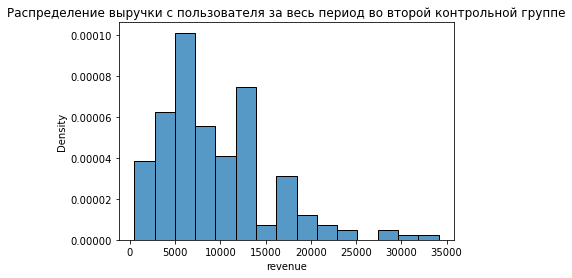

In [32]:
sns.histplot(data=money_per_user_2.query('revenue < 50000'), x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Распределение выручки с пользователя за весь период во второй контрольной группе");

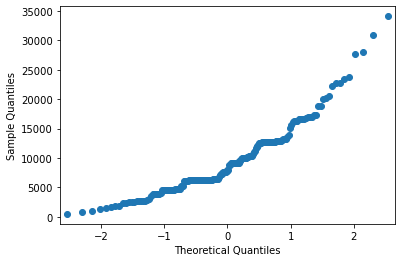

In [33]:
sm.qqplot(money_per_user_2.query('revenue < 50000').revenue)
plt.show()

In [37]:
stats.normaltest(money_per_user_2.query('revenue < 50000').revenue)

NormaltestResult(statistic=45.90705980132836, pvalue=1.0750003952739721e-10)

### Распределение не является нормальным, так как pvalue << 0.05

In [140]:
statss.kruskal(money_per_user.revenue.values, money_per_user_2.revenue.values)

KruskalResult(statistic=1.0990334987088128, pvalue=0.29447830879724957)

### Для сравнения медианных значений контрольных групп применен критерий Краскелла-Уоллиса
### Результат тестирования показывает, что две контрольные группы не имеют статистически значимых отличий

#### Посмотрим аналогично распределение среднего чека на пользователя в тестовой группе, а так же проверим его на нормальность

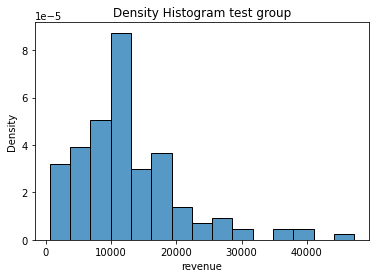

In [42]:
money_per_user_test = transactions_test.groupby('uid', as_index=False).agg({'revenue': 'sum'})
money_per_user_test
sns.histplot(data=money_per_user_test.query('revenue < 50000'), x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Density Histogram test group");

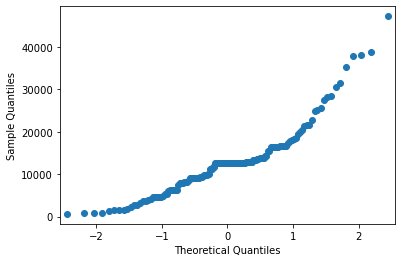

In [43]:
sm.qqplot(money_per_user_test.query('revenue < 50000').revenue)
plt.show()

In [44]:
stats.normaltest(money_per_user_test.query('revenue < 50000').revenue)

NormaltestResult(statistic=44.825980968947526, pvalue=1.8457033889585614e-10)

#### Распределение ARPU в тестовой группе не является нормальным

In [49]:
statss.kruskal(money_per_user.revenue.values, money_per_user_test.revenue.values)

KruskalResult(statistic=13.03229693626981, pvalue=0.00030616480773363637)

## Так как при сравнении критерием Краскелла-Уоллиса распределений ARPU в контрольных группах мы не получили статзначимых отличий, а в первой контрольной и тестовой получили, то для сравнения разницы средних рассмотрим первую контрольную и тестовую группы

#### Из-за ненормальности распределений выбран бутстрап, хорошо показывающий результаты для данного случая

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2120.18it/s]


13537.63579077
2524.0080469500003
[1724.1002349999992, 3288.367744999998]


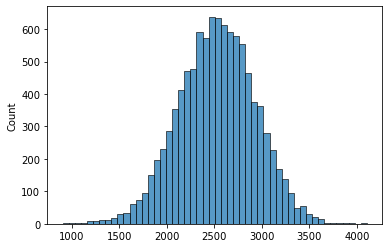

In [50]:
 bootstrap(money_per_user,money_per_user_test)

### По результатам бутстрапа получаем, что распределение разницы средних между тестовой и контрольной группами, где из тестовой группы вычитаеся контрольная, имеет среднее со значением 2524 с границами 95-ти% доверительного интервала [1724.1, 3288.4]

## Тогда, средняя разница выручки по пользователю (ARPU) увеличилась на 2524 денежных единиц, что показывает рост денег с одного пользователя

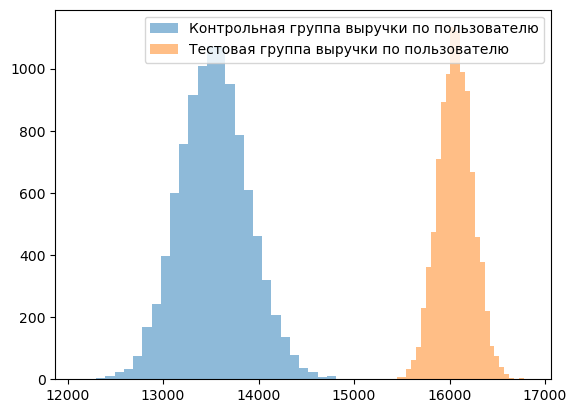

In [99]:
import matplotlib.pyplot as plt

plt.hist(bank_control, alpha=0.5, label='Контрольная группа выручки по пользователю', bins = 30)
plt.hist(bank_test, alpha=0.5, label='Тестовая группа выручки по пользователю', bins = 30)

plt.legend()
plt.show()

### Визуализация распределений средних первой контрольной и тестовой групп

### Посмотрим, как распределяются люди в зависимости от вида покупок, совершенных в приложении

#### Таблицы количества покупок каждого вида подписки и выручка за эти виды покупок для каждой из 4х рассматриваемых групп по типу продукта, продаваемого приложением

In [52]:
money_prod_type = control_1.groupby('product_type').agg({'uid': 'count', 'revenue': 'sum'})
money_prod_type['percent'] = money_prod_type['revenue'] / money_prod_type['revenue'].sum() * 100
money_prod_type

,uid,revenue,percent
product_type,,,
coins,149,871910.0,33.376960
other_type,55,188422.0,7.212847
premium_no_trial,106,779259.0,29.830254
trial_premium,67,772720.0,29.579939


In [53]:
money_prod_type2 = control_2.groupby('product_type').agg({'uid': 'count', 'revenue': 'sum'})
money_prod_type2['percent'] = money_prod_type2['revenue'] / money_prod_type2['revenue'].sum() * 100
money_prod_type2

,uid,revenue,percent
product_type,,,
coins,124,402909,20.980058
other_type,44,128739,6.703627
premium_no_trial,107,744809,38.783288
trial_premium,53,643981,33.533027


In [54]:
money_prod_type3 = test.groupby('product_type').agg({'uid': 'count', 'revenue': 'sum'})
money_prod_type3['percent'] = money_prod_type3['revenue'] / money_prod_type3['revenue'].sum() * 100
money_prod_type3

,uid,revenue,percent
product_type,,,
coins,106,566176,24.144985
other_type,29,167817,7.156677
premium_no_trial,76,810706,34.573144
trial_premium,62,800202,34.125193


### Сравним по хи квадрату различие в распределении людей в зависимости от типа покупок

In [56]:
stats.chisquare(f_obs=[146, 40, 105, 86], f_exp=[149, 55, 106, 67])     # первая контрол и тест

Power_divergenceResult(statistic=9.548805439229536, pvalue=0.02281778080266375)

In [57]:
stats.chisquare(f_obs=[128, 35, 91, 74], f_exp=[124, 44, 107, 53])     # вторая контрол и тест

Power_divergenceResult(statistic=12.683219430440719, pvalue=0.005374235584014063)

In [58]:
stats.chisquare(f_obs=[143, 50, 123, 61], f_exp=[149, 55, 106, 67])    # контрол группы

Power_divergenceResult(statistic=3.959884719975932, pvalue=0.26582856409174677)

### Контрольные группы не отличаются статзначимо в распределениях видов покупок людей, в отличие от каждой из контрольных и тестовой группой
### P-value принимает значения меньшие 0.05 при сравнении контрольных групп с тестом (0.0228 и 0.0054)

##  Рассмотрим распределение ARPU в группах по покупкам и сравним группы между собой

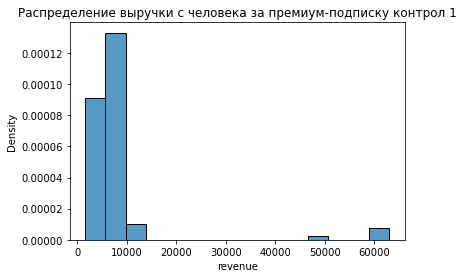

In [62]:
buy_prem = control_1.query('product_type == "premium_no_trial"').groupby('uid').agg({'revenue':'sum'})
sns.histplot(data=buy_prem, x='revenue', bins=15, stat='density', common_norm=False);
plt.title('Распределение выручки с человека за премиум-подписку контрол 1');

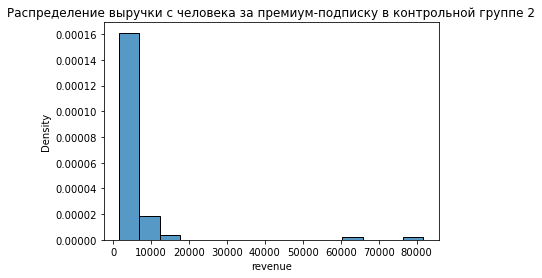

In [59]:
buy_prem2 = control_2.query('product_type == "premium_no_trial"').groupby('uid').agg({'revenue':'sum'})
sns.histplot(data=buy_prem2, x='revenue', bins=15, stat='density', common_norm=False);
plt.title('Распределение выручки с человека за премиум-подписку в контрольной группе 2');

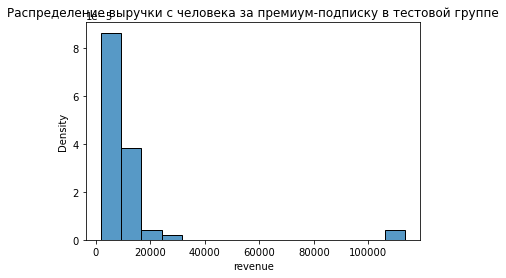

In [60]:
buy_prem_test = test.query('product_type == "premium_no_trial"').groupby('uid').agg({'revenue':'sum'})
sns.histplot(data=buy_prem_test, x='revenue', bins=15, stat='density', common_norm=False);
plt.title('Распределение выручки с человека за премиум-подписку в тестовой группе');

In [64]:
statss.kruskal(buy_prem.revenue.values, buy_prem2.revenue.values)

KruskalResult(statistic=0.2514584292931297, pvalue=0.616050019632918)

In [65]:
statss.kruskal(buy_prem.revenue.values, buy_prem_test.revenue.values)

KruskalResult(statistic=29.393497982068027, pvalue=5.9075515429423225e-08)

### Статзначимого различия между контрольными группами нет, а между первой контрольной и тестовой группах есть, поэтому проверим, как изменилось ARPU в группе людей, купивших премиумную подписку, на которую изменили цену

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2082.68it/s]


7872.283729440001
4226.952309969999
[3822.085995, 4654.411515]


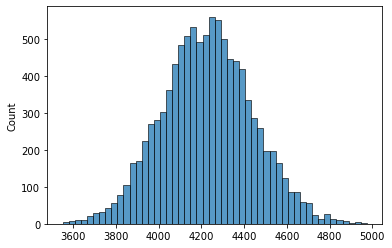

In [66]:
bootstrap(buy_prem,buy_prem_test)

### Делаем вывод, что именно для нашей премиум-подписки, у которой изменилась цена на протяжении всего рассматриваемого периода выручка по клиенту (ARPU) увеличилась в среднем на 4226 с границами 95% доверительного интервала [3822, 4654]
### Изменение статзначимо, так как границы доверительного интервала не включают в себя 0
### Следовательно, трата с человека на премиум-подписку выросла

### Проведем аналогичные исследования для остальных видов трат в приложении, в данной работе представлены итоговые результаты

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2339.57it/s]


11533.078610690001
1584.93254647
[1514.5566799999992, 1656.6992324999992]


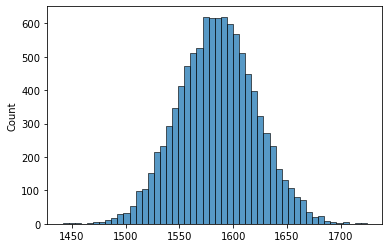

In [68]:
bootstrap(control_1.query('product_type == "trial_premium"').groupby('uid').agg({'revenue':'sum'}),test.query('product_type == "trial_premium"').groupby('uid').agg({'revenue':'sum'}))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2207.08it/s]


6282.301201800001
2550.3188344400005
[2233.1042174999993, 2876.6307049999996]


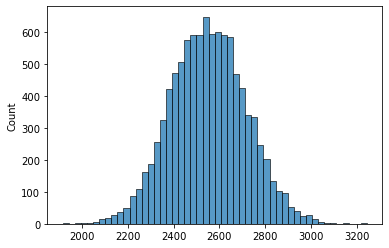

In [69]:
bootstrap(control_1.query('product_type == "other_type"').groupby('uid').agg({'revenue':'sum'}),test.query('product_type == "other_type"').groupby('uid').agg({'revenue':'sum'}))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2136.10it/s]


13414.24746363
-2523.89597356
[-3499.9210675000004, -1577.4939699999995]


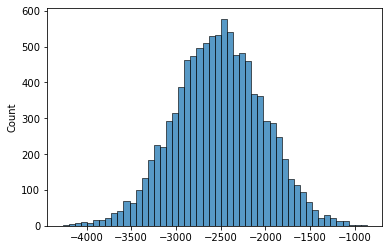

In [70]:
bootstrap(control_1.query('product_type == "coins"').groupby('uid').agg({'revenue':'sum'}),test.query('product_type == "coins"').groupby('uid').agg({'revenue':'sum'}))

## В остальных видах покупок ARPU статзначимо вырос, за исключением падения в группе покупок монет приложения

### Теперь взглянем на сумму средней транзакции, совершенной пользователем

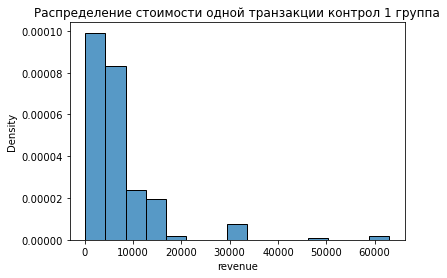

In [21]:
money_per_trans_1 = transactions_control_1
money_per_trans_1
sns.histplot(data=money_per_trans_1, x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Распределение стоимости одной транзакции контрол 1 группа");

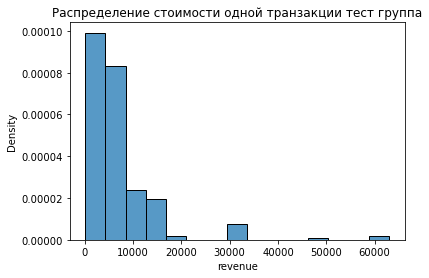

In [22]:
money_per_trans_t = transactions_test
money_per_trans_t
sns.histplot(data=money_per_trans_1, x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Распределение стоимости одной транзакции тест группа");

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2136.30it/s]


6929.94826433
1658.6687549899998
[1387.964695, 1931.5352550000005]


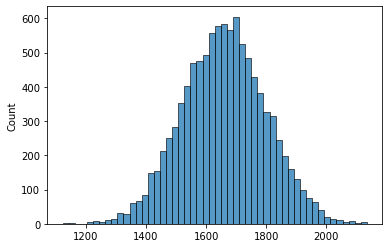

In [23]:
bootstrap(money_per_trans_1,money_per_trans_t)

### По проведеному тесту можно сделать вывод, что сумма одной транзакции с пользователя за весь период эксперимента статзначимо выросла в среднем на 1658 с границами доверительного интервала [1388, 1931]

## Рассмотрим распределение транзакций во всех группах

Text(0.5, 1.0, 'Транзакции совершенные в периоды по месяцам контрольная группа 1')

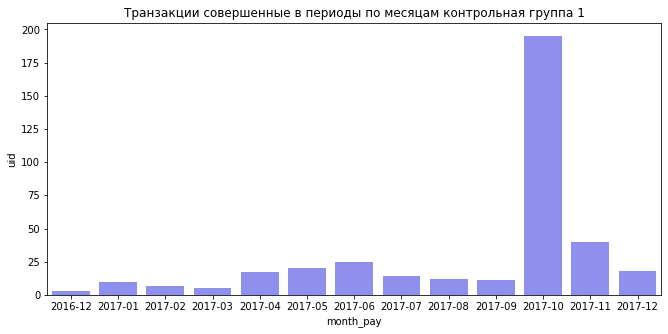

In [31]:
transactions_control_1['paid_at'] = pd.to_datetime(transactions_control_1['paid_at'])
transactions_control_1['month_pay'] = transactions_control_1["paid_at"].dropna().dt.to_period("M")
transactions_control_1 = transactions_control_1.dropna()
transactions_control_1
sum_users = transactions_control_1.groupby('month_pay').agg({'uid':'count'}).reset_index()

plt.figure(figsize=(11, 5))
sns.barplot(x=sum_users.month_pay, y=sum_users.uid, data=sum_users, color='blue', alpha=0.5)
plt.title('Транзакции совершенные в периоды по месяцам контрольная группа 1')

Text(0.5, 1.0, 'Транзакции совершенные в периоды по месяцам контрольная группа 2')

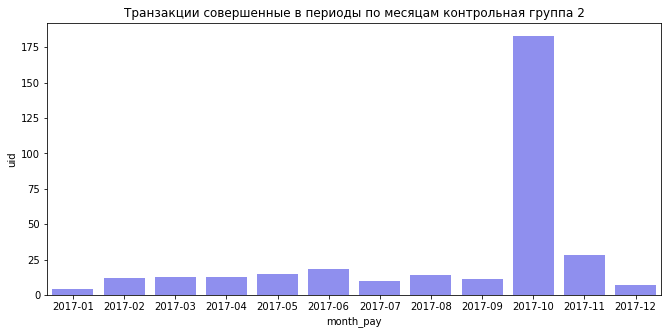

In [32]:
transactions_control_2['paid_at'] = pd.to_datetime(transactions_control_2['paid_at'])
transactions_control_2['month_pay'] = transactions_control_2["paid_at"].dropna().dt.to_period("M")
transactions_control_2 = transactions_control_2.dropna()
transactions_control_2
sum_users = transactions_control_2.groupby('month_pay').agg({'uid':'count'}).reset_index()

plt.figure(figsize=(11, 5))
sns.barplot(x=sum_users.month_pay, y=sum_users.uid, data=sum_users, color='blue', alpha=0.5)
plt.title('Транзакции совершенные в периоды по месяцам контрольная группа 2')

Text(0.5, 1.0, 'Транзакции совершенные в периоды по месяцам тестоввая группа')

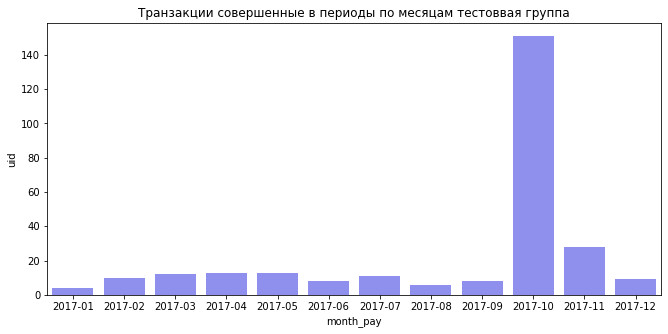

In [33]:
transactions_test['paid_at'] = pd.to_datetime(transactions_test['paid_at'])
transactions_test['month_pay'] = transactions_test["paid_at"].dropna().dt.to_period("M")
transactions_test = transactions_test.dropna()
transactions_test
sum_users_test = transactions_test.groupby('month_pay').agg({'uid':'count'}).reset_index()

plt.figure(figsize=(11, 5))
sns.barplot(x=sum_users_test.month_pay, y=sum_users_test.uid, data=sum_users_test, color='blue', alpha=0.5)
plt.title('Транзакции совершенные в периоды по месяцам тестоввая группа')

### Видим, что наибольшее количество транзакций сделано в октябре 2017 года, а затем в ноябре 2017, из чего можем сделать вывод о проводимой в приложении какой-либо акции или другой активности, побудившей пользователей совершить покупку.

### Проведем когортный анализ для конверсии совершения транзакций в последующие месяцы

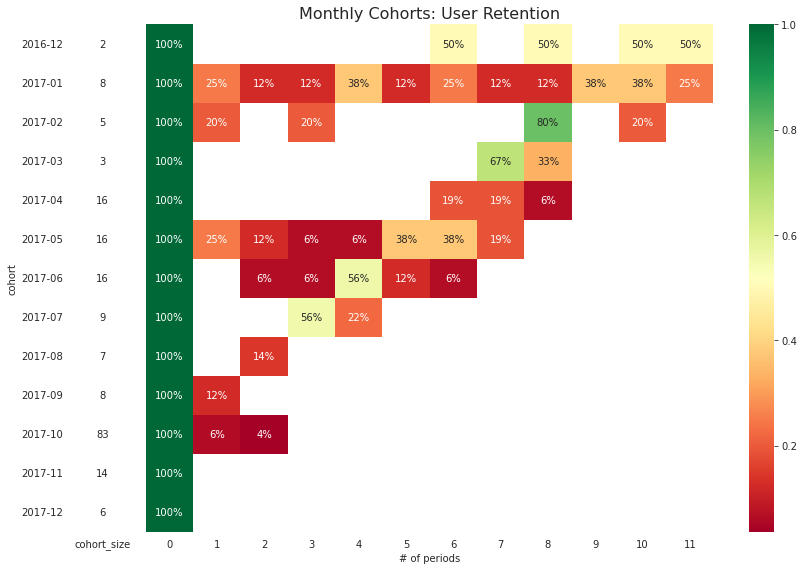

In [77]:
cog_matrix(table_cog(transactions_control_1))

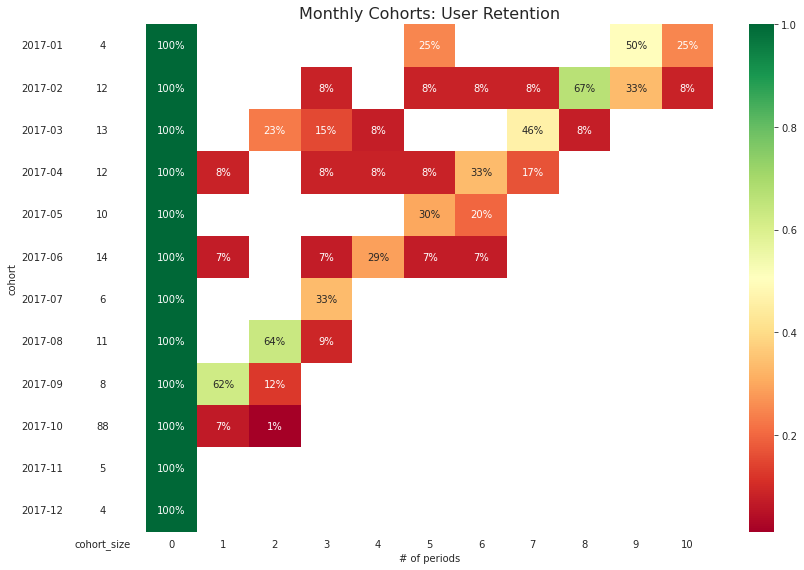

In [78]:
cog_matrix(table_cog(transactions_control_2))

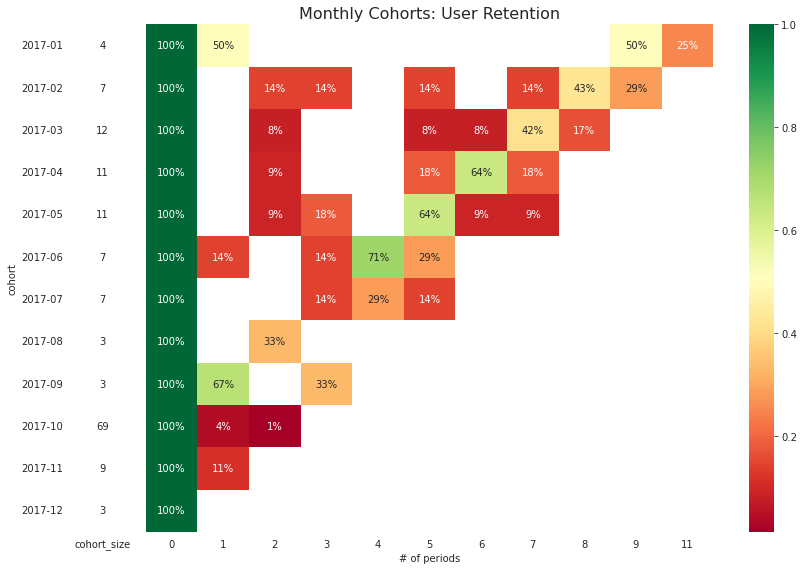

In [79]:
cog_matrix(table_cog(transactions_test))

### Также построим когорты для конверсии посещений людьми приложения в последующие месяцы

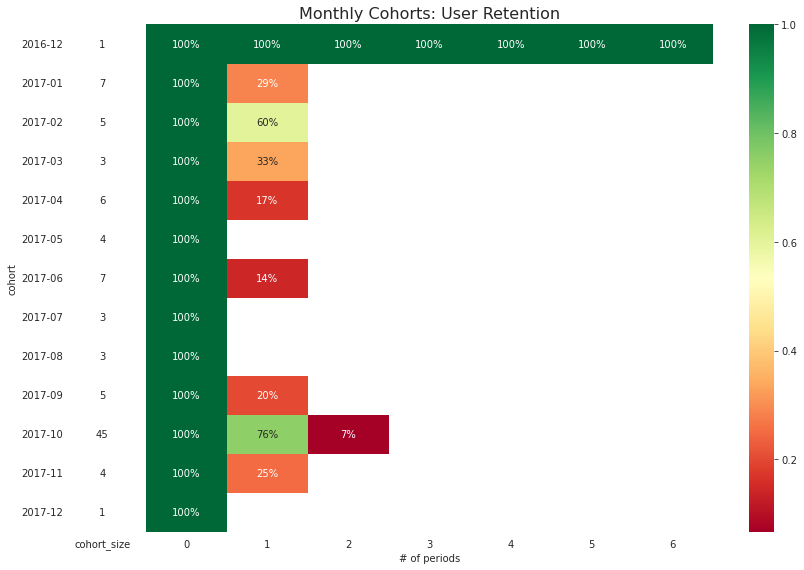

In [84]:
cog_matrix(table_cog_visits(convert_visits(control_1)))

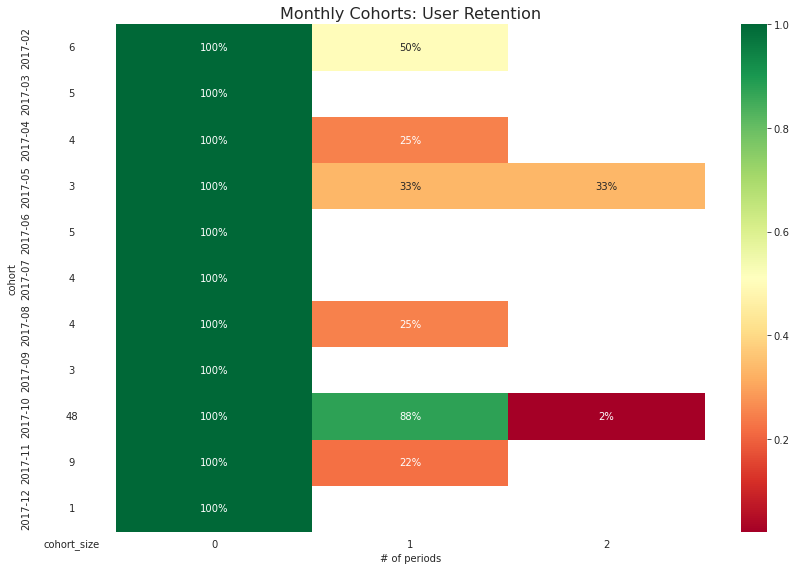

In [85]:
cog_matrix(table_cog_visits(convert_visits(control_2)))

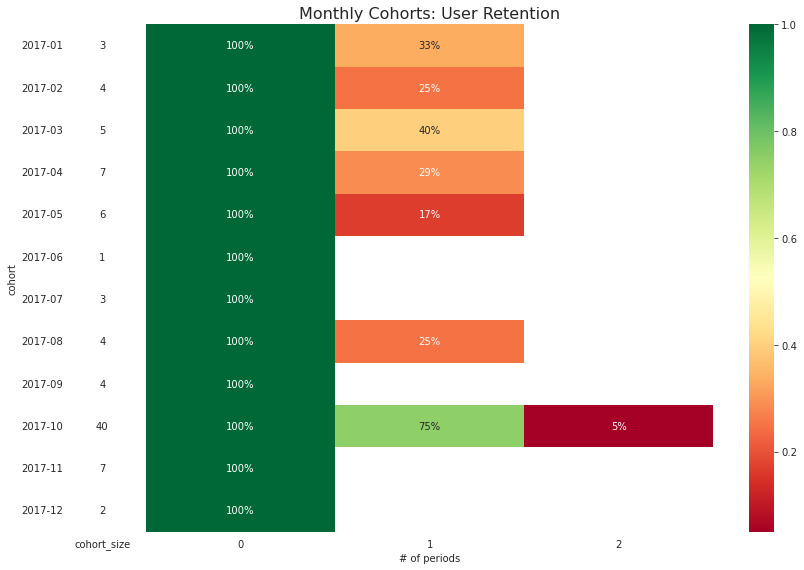

In [86]:
cog_matrix(table_cog_visits(convert_visits(test)))

## Делаем вывод, что когорта транзакций несколько не соответствует когорте посещений, так как транзакции, совершаемые людьми, выполнялись без захода в приложение (за исключением месяца 10-2017)
### Вследствие этого в дальнейшем будем рассматривать конверсии транзакций и посещений в следующий месяц за октябрь 2017 года

#### Проведем предобработку колонки месяца с переводом ее в формат строки

In [37]:
transactions_control_1['month_pay'] = transactions_control_1["paid_at"].dropna().dt.to_period("M").apply(lambda x: str(x))
transactions_control_2['month_pay'] = transactions_control_2["paid_at"].dropna().dt.to_period("M").apply(lambda x: str(x))
transactions_test['month_pay'] = transactions_test["paid_at"].dropna().dt.to_period("M").apply(lambda x: str(x))

### Проверим, статзначимо ли отличаются контрольные группы в сравнении с тестовой в отношении конверсии покупки в следующий месяц на период октября-ноября 2017 года

In [155]:
transactions_control_1_10mon = transactions_control_1.query('month_pay == "2017-10"').uid.unique()

In [156]:
len(transactions_control_1_10mon)

118

In [227]:
len(transactions_control_1.query('month_pay == "2017-11" and uid in @transactions_control_1_10mon').uid.unique())

18

In [225]:
conversion_people_10mon_1 = len(transactions_control_1.query('month_pay == "2017-11" and uid in @transactions_control_1_10mon').uid.unique()) \
                            / len(transactions_control_1_10mon)
conversion_people_10mon_1

0.15254237288135594

In [158]:
transactions_control_2_10mon = transactions_control_2.query('month_pay == "2017-10"').uid.unique()

In [226]:
conversion_people_10mon_2 = len(transactions_control_2.query('month_pay == "2017-11" and uid in @transactions_control_2_10mon').uid.unique()) \
                            / len(transactions_control_2_10mon)
conversion_people_10mon_2

0.13178294573643412

In [160]:
len(transactions_control_2_10mon)

129

In [228]:
len(transactions_control_2.query('month_pay == "2017-11" and uid in @transactions_control_2_10mon').uid.unique())

17

In [130]:
transactions_control_test_10mon = transactions_test.query('month_pay == "2017-10"').uid.unique()

In [229]:
conversion_people_10mon_test = len(transactions_test.query('month_pay == "2017-11" and uid in @transactions_control_test_10mon').uid.unique()) \
                            / len(transactions_control_test_10mon)
conversion_people_10mon_test

0.11764705882352941

In [163]:
len(transactions_control_test_10mon)

102

In [230]:
len(transactions_test.query('month_pay == "2017-11" and uid in @transactions_control_test_10mon').uid.unique())

12

In [134]:
stats.chisquare(f_obs=[18, 118], f_exp=[14, 122])     # первая контрол и тест

Power_divergenceResult(statistic=1.2740046838407493, pvalue=0.2590167462031468)

In [135]:
stats.chisquare(f_obs=[17, 129], f_exp=[15.4, 130.6])     # вторая контрол и тест

Power_divergenceResult(statistic=0.18583560390604778, pvalue=0.6664054481007753)

## Тестовая группа в отношении конверсий статзначимо не отличается от первой контрольной группы при применении критерия Хи-квадрат

### Проведем бутстрап между 1 контрольной группой и тестовой группой для еще одной проверки полученного результата

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8893.40it/s]


0.13211
-0.015060000000000002
[-0.1, 0.07]


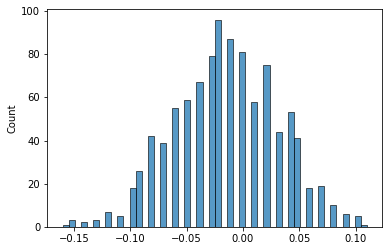

In [58]:
control_arr  = [1]*17 + [0]*(129-17)
test_arr     = [1]*12 + [0]*(102-12)
bank_control = []
bank_test    = []
bank         = []
    
n = 1000
m = 100
for i in tqdm(range(n)):
                
    samp_control = np.random.choice(control_arr, size = m, replace = True)
    samp_test    = np.random.choice(test_arr, size = m, replace = True)
        
    bank_control.append(np.mean(samp_control))
    bank_test.append(np.mean(samp_test))
        
    bank.append(np.mean(samp_test) - np.mean(samp_control))
        
sns.histplot(pd.Series(bank), bins=50)
    
print(np.mean(bank_control))
print(np.mean(bank))
print([np.quantile(bank, q=0.025), np.quantile(bank, q=0.975)])

## По результатам проведения бутстрапа и критерия хи-квадрат статзначимого отличия между тестовой и контрольными группами не выявлено. P-value для критерия хи-квадрат >> 0.05, а в бутстрапе границы доверительного интервала включают в себя 0, что не позволяет нам сказать о статзначимых отличиях

## Из чего мы можем делать вывод, что ARPU на пользователя выросло, а конверсия для покупок в последующий месяц статзначимо не изменилась, поэтому, делаем вывод, что общая прибыль в целом увеличилась, и изменения стоит вкатывать

### Рассмотрим распределение совершенных транзакций по странам
### Возьмем страны, в которых выполнено хотя бы более 25 транзакций, так как суммарное число транзакций, представленное в данных, очень невелико (см размеры датафреймов транзакций), а количество разных стран более 15

In [183]:
transactions_control_1.groupby('country').count().shape

(18, 10)

In [184]:
transactions_control_2.groupby('country').count().shape

(19, 10)

In [182]:
transactions_test.groupby('country').count().shape

(17, 10)

Text(0.5, 1.0, 'Транзакции совершенные по странам контрол группа 1')

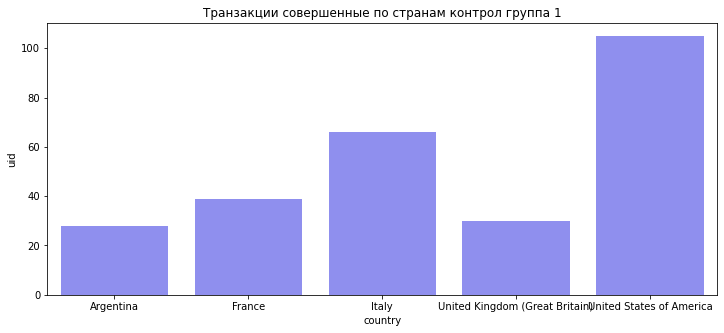

In [192]:
sum_users = transactions_control_1.groupby('country').agg({'uid':'count'}).reset_index()
sum_users = sum_users.query('uid > 25')
plt.figure(figsize=(12, 5))
sns.barplot(x=sum_users.country, y=sum_users.uid, data=sum_users, color='blue', alpha=0.5)
plt.title('Транзакции совершенные по странам контрол группа 1')

Text(0.5, 1.0, 'Транзакции совершенные по странам контрол группа 2')

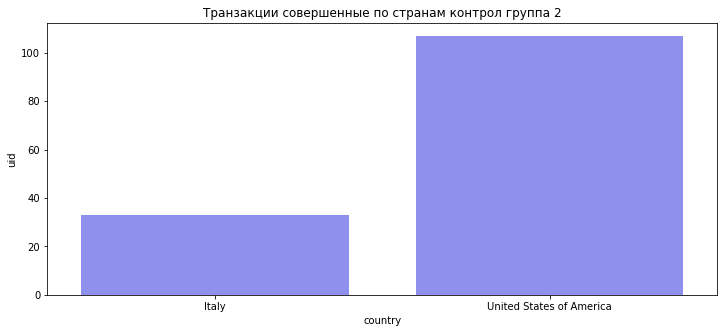

In [189]:
sum_users2 = transactions_control_2.groupby('country').agg({'uid':'count'}).reset_index()
sum_users2 = sum_users2.query('uid > 25')
plt.figure(figsize=(12, 5))
sns.barplot(x=sum_users2.country, y=sum_users2.uid, data=sum_users2, color='blue', alpha=0.5)
plt.title('Транзакции совершенные по странам контрол группа 2')

Text(0.5, 1.0, 'Транзакции совершенные по странам тест группа')

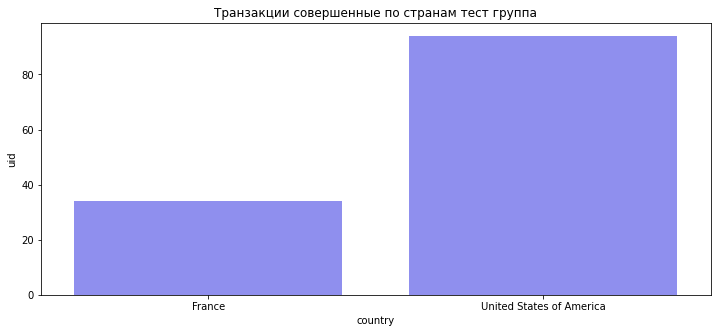

In [190]:
sum_userst = transactions_test.groupby('country').agg({'uid':'count'}).reset_index()
sum_userst = sum_userst.query('uid > 25')
plt.figure(figsize=(12, 5))
sns.barplot(x=sum_userst.country, y=sum_userst.uid, data=sum_userst, color='blue', alpha=0.5)
plt.title('Транзакции совершенные по странам тест группа')

### Судя по распределению транзакций по странам, наибольшее количество транзакций совершено в США, в других же странах, их количество не достигает установленного нами предела во всех 3х рассматриваемых группах

### Рассмотрим США в отношении изменения среднего чека на пользователя

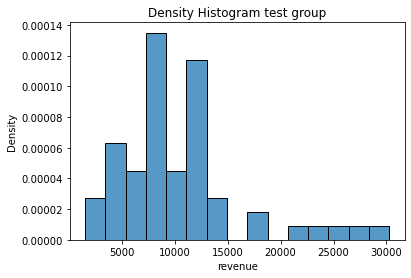

In [216]:
money_per_user_Am_1 = transactions_control_1.query('country == "United States of America"').groupby('uid', as_index=False).agg({'revenue': 'sum'})
money_per_user_Am_1
sns.histplot(data=money_per_user_Am_1.query('revenue < 50000'), x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Density Histogram test group");

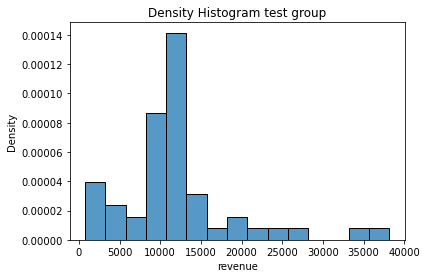

In [219]:
money_per_user_Am_t = transactions_test.query('country == "United States of America"').groupby('uid', as_index=False).agg({'revenue': 'sum'})
money_per_user_Am_t
sns.histplot(data=money_per_user_Am_t.query('revenue < 50000'), x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Density Histogram test group");

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2941.98it/s]


12398.52328897
1486.3328829700001
[1146.076555, 1829.5086549999999]


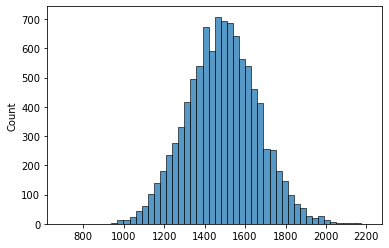

In [232]:
bootstrap(money_per_user_Am_1,money_per_user_Am_t)

### По проведеному тесту можно сделать вывод, что ARPU с пользователя в Америке статзначимо выросло в среднем на 1486 с границами доверительного интервала [1146, 1829]

#### Теперь взглянем на сумму средней транзакции, совершенной пользователем

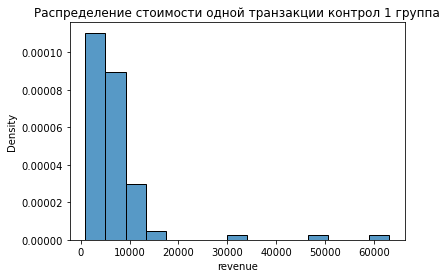

In [26]:
money_per_user_Am_1 = transactions_control_1.query('country == "United States of America"')
money_per_user_Am_1
sns.histplot(data=money_per_user_Am_1, x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Распределение стоимости одной транзакции контрол 1 группа");

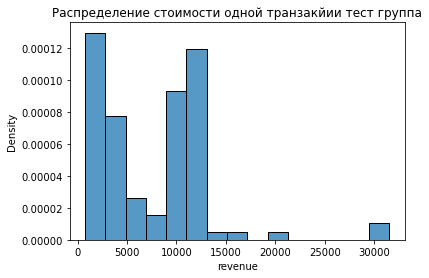

In [25]:
money_per_user_Am_t = transactions_test.query('country == "United States of America"')
money_per_user_Am_t
sns.histplot(data=money_per_user_Am_t, x='revenue', bins=15, stat='density', common_norm=False);
plt.title("Распределение стоимости одной транзакции тест группа");

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2586.87it/s]


7084.774645389999
595.19456646
[399.7506825000003, 792.5028799999997]


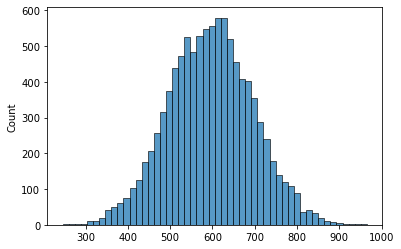

In [27]:
bootstrap(money_per_user_Am_1,money_per_user_Am_t)

### По проведеному тесту можно сделать вывод, что сумма одной транзакции с пользователя в Америке статзначимо выросла в среднем на 595 с границами доверительного интервала [399, 792]

### Конверсия американцев в следующий месяц (для 10-2017)

In [39]:
transactions_control_1_Am = transactions_control_1.query('month_pay == "2017-10" and country == "United States of America"').uid.unique()

In [40]:
len(transactions_control_1_Am)

37

In [41]:
len(transactions_control_1.query('month_pay == "2017-11" and uid in @transactions_control_1_Am').uid.unique())

6

In [43]:
conversion_people_Am_1 = len(transactions_control_1.query('month_pay == "2017-11" and uid in @transactions_control_1_Am').uid.unique()) \
                            / len(transactions_control_1_Am)
conversion_people_Am_1

0.16216216216216217

In [49]:
transactions_control_test_Am = transactions_test.query('month_pay == "2017-10" and country == "United States of America"').uid.unique()

In [51]:
conversion_people_Am_test = len(transactions_test.query('month_pay == "2017-11" and uid in @transactions_control_test_Am').uid.unique()) \
                            / len(transactions_control_test_Am)
conversion_people_Am_test

0.1

In [52]:
len(transactions_control_test_Am)

40

In [53]:
len(transactions_test.query('month_pay == "2017-11" and uid in @transactions_control_test_Am').uid.unique())

4

In [54]:
stats.chisquare(f_obs=[6.14, 37.86], f_exp=[4, 40])     # первая контрол и тест

Power_divergenceResult(statistic=1.2593899999999996, pvalue=0.26176658684577925)

## Тестовая группа в отношении конверсий статзначимо не отличается от первой контрольной группы при применении критерия Хи-квадрат

### Проведем бутстрап между 1 контрольной группой и тестовой группой для еще одной проверки полученного результата

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9340.27it/s]


0.16141
-0.06110000000000001
[-0.15999999999999998, 0.03]


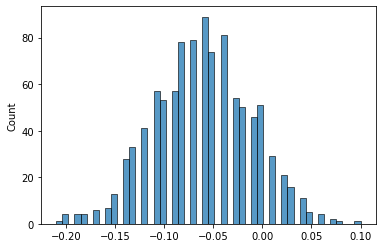

In [57]:
control_arr  = [1]*6 + [0]*(37-6)
test_arr     = [1]*4 + [0]*(40-4)
bank_control = []
bank_test    = []
bank         = []
    
n = 1000
m = 100
for i in tqdm(range(n)):
                
    samp_control = np.random.choice(control_arr, size = m, replace = True)
    samp_test    = np.random.choice(test_arr, size = m, replace = True)
        
    bank_control.append(np.mean(samp_control))
    bank_test.append(np.mean(samp_test))
        
    bank.append(np.mean(samp_test) - np.mean(samp_control))
        
sns.histplot(pd.Series(bank), bins=50)
    
print(np.mean(bank_control))
print(np.mean(bank))
print([np.quantile(bank, q=0.025), np.quantile(bank, q=0.975)])

### По результатам проведения бутстрапа и критерия хи-квадрат статзначимого отличия между тестовой и контрольными группами не выявлено. P-value для критерия хи-квадрат >> 0.05, а в бутстрапе границы доверительного интервала включают в себя 0, что не позволяет нам сказать о статзначимых отличиях
## Таким образом, и для Америки конверсия в следующие покупки не отличается от контрольной группы, а ARPU растет, значит, суммарная выруска после изменений в Америке увеличится, и для Америки стоит вкатывать изменения

# ВЫВОДЫ

## Для всех пользователей:

### За время эксперимента в тестовой группе ARPU:

#### 1. ARPU общий (для всех категорий покупок) в среднем статзначимо увеличился на 2524 денежных единиц за все время проведения эксперимента (с 13537 д.е. до 16061 д.е., на 18,6%) с границами 95-ти% доверительного интервала [1724.1, 3288.4]
#### 2. ARPU по категориям покупок в приложении за все время :
        - по категории премиум-подписки (в нее вкатили изменение):статзначимо увеличено в среднем на  4226.9 денежных единиц, с 7872 до 12098 д.е. (на 53,6%) с границами 95-ти% доверительного интервала [3822.08, 4654.41]
        
        - по категории премиум-подписки пробной версии:           статзначимо увеличено в среднем на  1584.9 денежных единиц, с 11533 до 13117 д.е. (на 13,7%) с границами 95-ти% доверительного интервала [1514.56 1656.7]
        
        - по категории покупок монет(валюта приложения):          статзначимо уменьшено в среднем на -2523.9 денежных единиц, с 13414 до 10891 (на 19%) с границами 95-ти% доверительного интервала [-3499.92, -1577.49]
        
        - по категории остальных трат в приложении:               статзначимо увеличено в среднем на  2550.3 денежных единиц, с 6282 до 8832 д.е. (на 40,5%) с границами 95-ти% доверительного интервала [2233.10, 2876.63]

#### 3. Средняя сумма транзакции, совершаемой в приложении за все время проведения эксперимента:
        Средняя сумма транзакции статзначимо увеличилась в среднем на 1658 д.е с 6929 до 8587 д.е. (на 24%) с границами 95-ти% доверительного интервала [1387.96, 1931.53]

### По проведенному анализу наблюдается увеличение средней выручки с пользователя после введения изменений во всех категориях, кроме категории покупок монет, популярность которых уменьшилась. Но, средняя выручка с пользователя по остальным категориям компенсирует данный убыток. Для нашей же интересующей категории (покупка премиум-подписки без пробной версии) происходит увеличение средней выручки с пользователя.

### Так же было замечено, что монеты стали покупаться в среднем на 2500 д.е. меньше, а остальные траты выросли на эти 2500 д.е., это интересаное наблюдение. Можно предположить, что есть отдельная категория людей, которые покупали монеты ранее, стали покупать другие виды товаров.

### По рассмотрению суммы одной транзакции так же было замечено статзначимое увеличение суммы одной транзакции в среднем на 24%

### Анализ пользователей:

#### 1. Конверсия пользователя в покупку в следующий месяц:
       В октябре 2017 года пользователи во всех рассматриваемых группах показали наибольшую конверсию, наблюдаемую по всем месяцам регистрации (от 12 до 80%). Возможно, такой прирост спровоцировала акция, проводимая в приложении, либо другая активность, побудившая пользователей вернуться в приложение.
        
        !! **Важное замечание** !!
        При рассмотрении данных дата регистрации пользователя для конверсионного анализа была взята из даты первой транзакции, совершенной пользователем, так как при рассмотрении дат регистрации и дат совершения транзакций были выявлены недочеты: дата первой транзакции могла быть раньше, чем дата регистрации пользователя, что в реалиях приложений должно быть невозможно.

        Для октября 2017 года, в который наблюдался приток пользователей и высокое возвращение старых пользователей была рассмотрена конверсия покупок в следуюющий месяц.
        Результаты тестирования НЕ ВЫЯВИЛИ статзначимого отличия конверсии покупки в следующий месяц. При сравнении контрольной и тестовой групп конверсия уменьшилась в среднем на 1,5% с 13% до 11,5% с границами 95-ти% доверительного интервала [-0.1, 0.07]%. Границы доверительного интервала включают в себя 0, значит, статзначимых отличий мы выявить не можем.

#### Визуализации когортного анализа для конверсии в покупку в следующий месяц

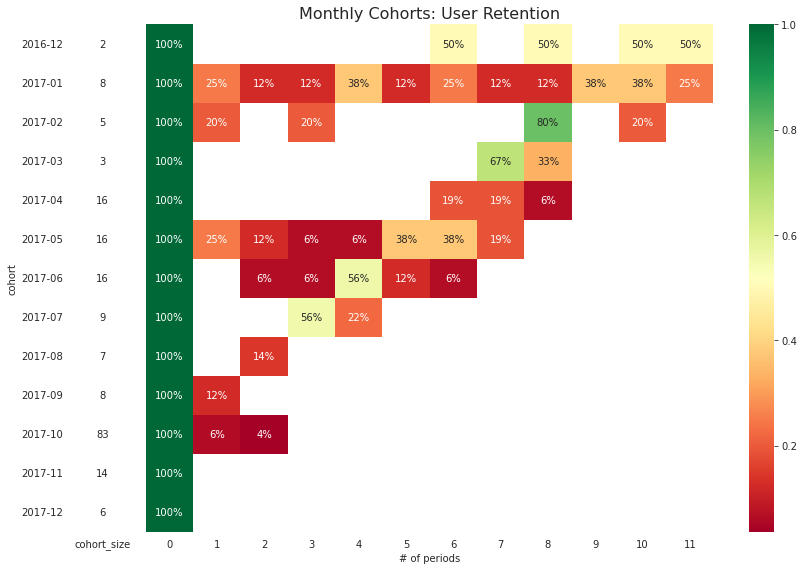

In [15]:
cog_matrix(table_cog(transactions_control_1))

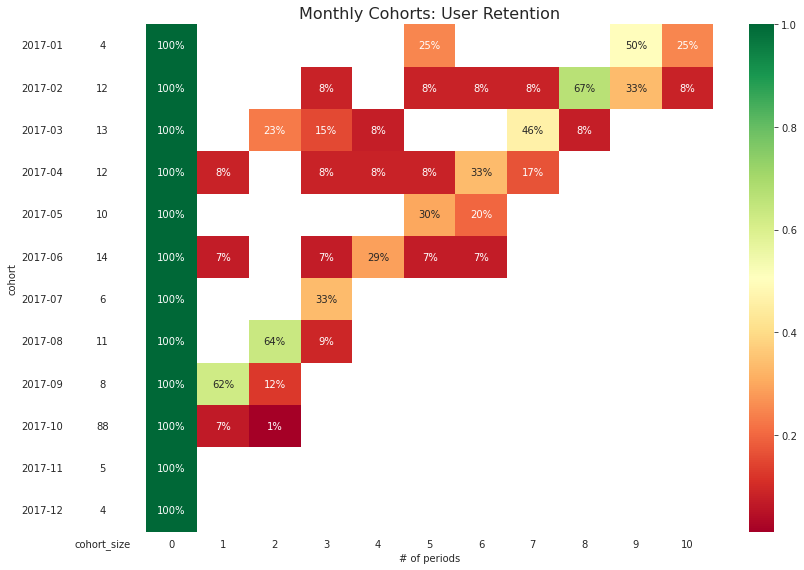

In [16]:
cog_matrix(table_cog(transactions_control_2))

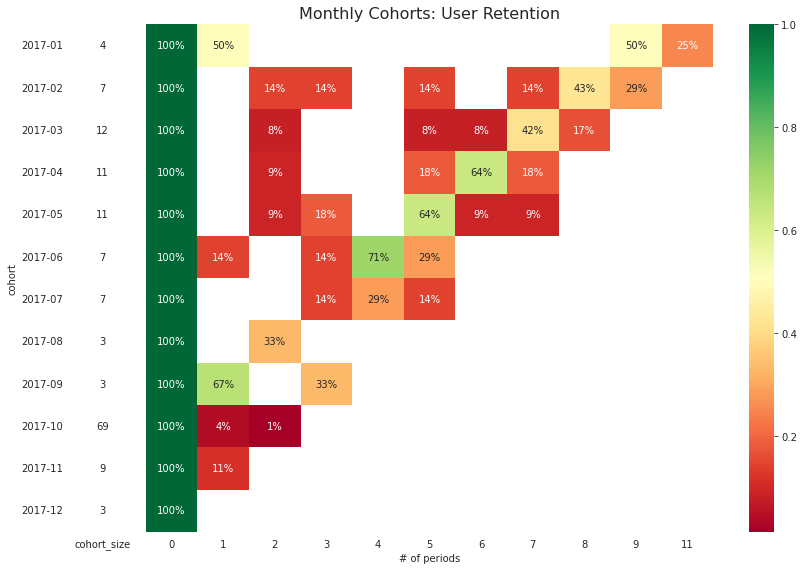

In [17]:
cog_matrix(table_cog(transactions_test))

#### Вследствие данного замечания, стоит дать рекомендации по обработке дат регистраций и совершения транзакций:
    - Alert на совершение транзакции пользователем до регистрации, если обе даты действительно существуют и соответстствуют действительности
    - Обработка действий совершения транзакций и регистрации пользователя должна быть последовательной. То есть при попытке фиксации действия база данных должна проверять, были ли зафиксированы какие-либо из проигнорированных операций (особенно операция регистрации пользователем в приложение).

#### 2. Конверсия пользователя в посещение им приложения в следующий месяц:

        По результатам построения когорты можно сделать вывод, что пользователи не посещают наше приложение в последующих месяцах* (за исключением автоматического списания денег за подписки у некоторых пользователей) из-за чего не представляется возможным сделать вывод для анализа конверсий.
        Наибольшая конверсия посещений пользователями наблюдается в октябре 2017 года, как и транзакции, так же связанная с активностью, проведенной в октябре. 
        
        *(за исключением 1 пользователя в 1 контрольной группе, зарегистрировавшегося в декабре 2016 года с 1 транзакцией - разработчик?)

#### Визуализации когортного анализа для конверсии в посещение пользователем приложения в следующий месяц

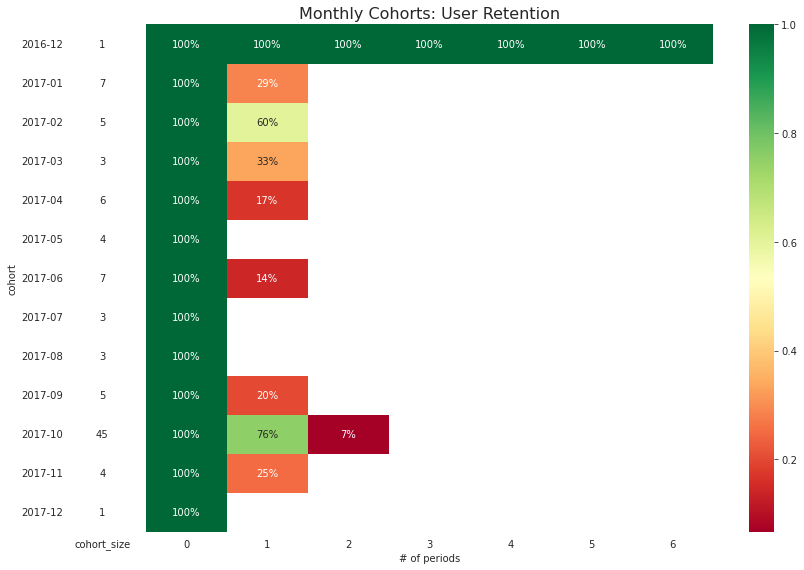

In [18]:
cog_matrix(table_cog_visits(convert_visits(control_1)))

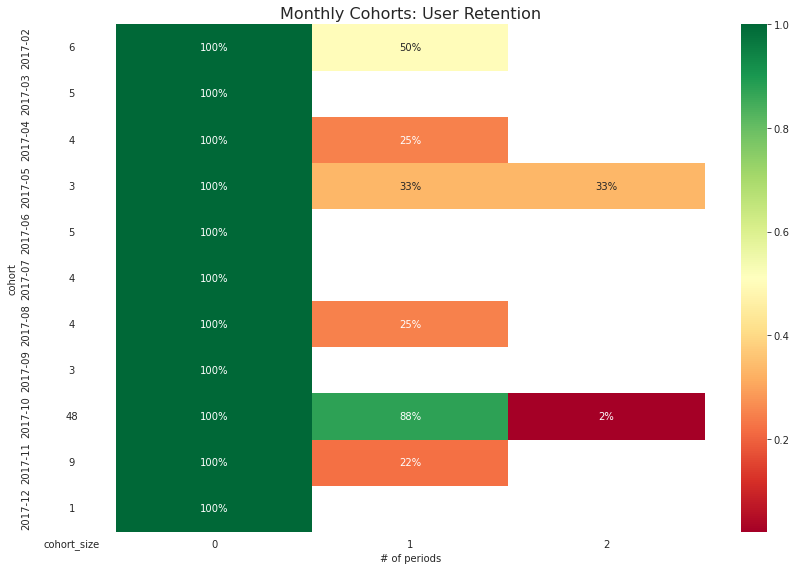

In [19]:
cog_matrix(table_cog_visits(convert_visits(control_2)))

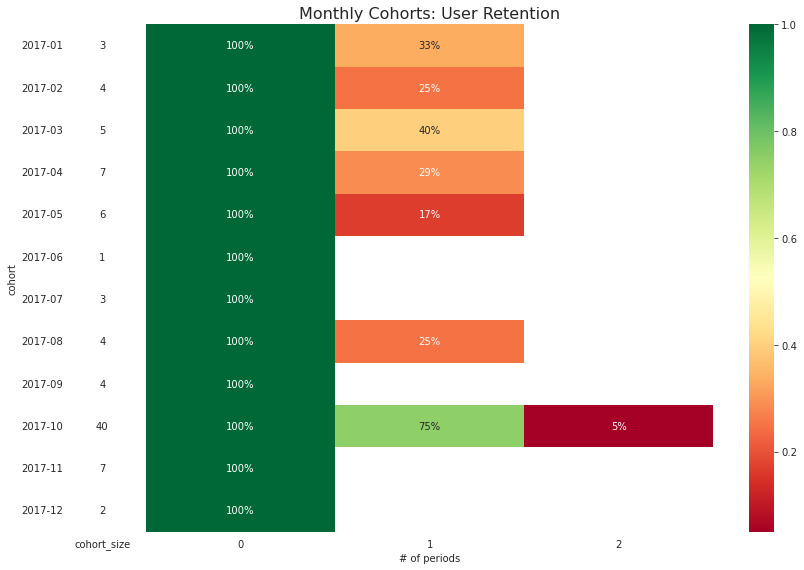

In [20]:
cog_matrix(table_cog_visits(convert_visits(test)))

### По проведенному анализу не наблюдалость статзначимых отличий в уменьшении/увеличении конверсий пользователей в отношении покупок в следующий месяц.

### Общий вывод по рассмотрению метрик ARPU и конверсий покупок в следующий месяц:
####    При рассмотрении ARPU пользователей (как по разным категориям, так и общий), средняя выручка с пользователя увеличилась. При рассмотрении конверсии в следующую покупку не было выявлено статзначимного отличия от контрпольной группы. 
####    В целом, это означает, что заработанная приложением сумма на протяжении всего времени выросла, и изменение стоит вносить.

## Для групп пользователей:

### В данной работе было рассмотрено разделение пользователей на страны

#### Разделение пользователей на страны:
        Разделение пользователей на страны (с условием, что в стране совершено хотя бы >25 транзакций) привело к тому, что во 2 контрольной группе и тестовой группе таких стран было выявлено всего 2. Это привело нас к тому, что было решено рассматривать страну, встречающуюся во всех 3х группах, это США, в которой было совершено около 100 транзакций (1/3 от всех транзакций, имеющихся у нас в данных). В остальных странах количество транзакций было менее 25, так как оставшиеся транзакции были распределены по большому количеству стран (>15). Вследствие этого были рассмотрены именно США

#### ARPU пользователей из США

        Общий ARPU за все время проведения эксперимента в Америке в среднем вырос на 1486 д.е с 12398 до 13884 д.е (на 12%) с границами 95-ти% доверительного интервала [1146.07, 1829.51]

#### Сумма одной транзакции пользователя из США

        Сумма одной транзакции за все время проведения эксперимента в Америке так же в среднем выросла на 595 д.е с 7084 до 7679 д.е (8,4%) с границами 95-ти% доверительного интервала [399.75, 792.50]

#### Анализ пользователей из США

        Конверсия пользователей в покупку в следующем месяце (на октябрь-ноябрь месяцы 2017 года) в среднем не изменилась. Конверсия в контрольной группе составляла 16,1%, в тестовой стала 10%. При проведении бутстрапа мы не выявили статзначимых отличий (в среднем изменилось на -6% с границами доверительного интервала [-0.16, 0.03]%). Границы доверительного интервала включают в себя 0, поэтому судить о статзначимости результата мы не можем.

#### Таким образом, средний чек с пользователя и сумма одной транзакции в США статзначимо увеличились на 12 и 8,4% соответственно. Конверсия пользователей в покупку следующего месяца не показала статзначимых изменений.
#### Следовательно, общая сумма выручки из США увеличилась. Изменение можно вносить в США

## ИТОГ

### По результатам проведенной работы выявлено, что изменения стоит вносить в США. Так же результаты показали, что на общем уровне всех пользователей изменение так же показало положительные результаты, и его стоит вкатывать.

### Рассмотрены ARPU за все время и по категориям покупок, сумма одной транзации для всех пользователей, конверсии покупок и посещений пользователей в следующие месяцы, разбивка на страны, средняя сумма одной транзакции для США